In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os
sys.path.append('../')
import mg_si
from imp import reload
reload(mg_si)
import pandas as pd
import scipy.interpolate as sint
import scipy.ndimage as sim
import itertools as it
from matplotlib.colors import ListedColormap
import time

In [2]:
df = pd.read_csv('../computed_solutions_new/run_data.csv')
df.columns

Index(['Time-date', 'time', 'T_cmb0', 'deltaT0', 'r_i', 'X_Mg_0', 'X_Si_0',
       'X_O_0', 'fraction_MgFe_b', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present',
       'layer_thickness', 'overturn'],
      dtype='object')

In [3]:
# Choose which columns to compute variations over
cols_to_ind = ['T_cmb0', 'deltaT0', 'X_Mg_0', 'X_Si_0',
       'X_O_0', 'fraction_MgFe_b', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present',
       'layer_thickness', 'overturn']

# convert dataframe to multiindex
ri_pd = df.set_index(cols_to_ind)

# drop any column which only has one value in the dataset
for i,l in enumerate(ri_pd.index.levels):
    if len(l) ==1:
        ri_pd.index = ri_pd.index.droplevel(l.name)

# drop the time and date column
ri_pd.drop(['time','Time-date'], axis=1, inplace=True)

# convert the pandas dataframe into a numpy nd-array
shape = list(map(len,ri_pd.index.levels))
ri_arr = np.full(shape, np.nan)
ri_arr[ri_pd.index.labels] = ri_pd.values.flat

# New, Fast Interpolate Code
Only computes interpolations when needed.

In [243]:
def setup_all_interpolation_axes(ric_pandas, Ninterp=20):
    fcoords = [] # interpolated index locations of values in dataset
    fvals = [] # values in dataset 
    fnames = [] # names of fit axes
    for ind in ri_pd.index.levels:
        vals = ind.values
        fnames.append(ind.name)
        mi = vals.min()
        ma = vals.max()
        fitvals = np.linspace(mi,ma,Ninterp)
        fitcoords = np.interp(fitvals, vals, range(len(vals)))
        fcoords.append(fitcoords)
        fvals.append(fitvals)
    return fnames, fcoords, fvals 

def get_interpolation_coords(ri_pd, name, vals_wanted=None, Ninterp=20, return_vals_wanted=False):
    ni = ri_pd.index.names.index(name)
    data_vals = ri_pd.index.levels[ni]
    if vals_wanted is None:
        mi = data_vals.min()
        ma = data_vals.max()
        vals_wanted = np.linspace(mi,ma,Ninterp)
    interp_coords = np.interp(vals_wanted, data_vals, range(len(data_vals)))
    if type(interp_coords) is float:
        interp_coords = np.array([interp_coords])
    if return_vals_wanted:
        return interp_coords, vals_wanted
    else:
        return interp_coords

def interpolate_2var_setothers(ri_pd, var1, var2, set_vals=dict(), Ninterp=20):
    interp_coords = []
    axes = []
    axnames = []
    for n in ri_pd.index.names:
        if (n == var1) or (n==var2):
            c,a = get_interpolation_coords(ri_pd, n, Ninterp=Ninterp, return_vals_wanted=True)
            if n == 'nu_present':
                a = np.log10(a*5500)
            axes.append(a)
            axnames.append(n)
            interp_coords.append(c)
        elif n in set_vals:
            v = set_vals[n]
            interp_coords.append(get_interpolation_coords(ri_pd, n, vals_wanted=v))
        else:
            raise ValueError('variable name {} not in model'.format(n))
    prod = it.product(*interp_coords, repeat=1)
    fit_ri = []
    for p in prod:
        fit_ri.append(sim.map_coordinates(ri_arr, np.array([p]).T, order=1))
    fit_ri = np.array(fit_ri)
    fit_ri = fit_ri.reshape([len(a) for a in axes])
    return fit_ri, axes, axnames
    
def plot_ri_misfit_contourf(ri_pd, var1, var2, set_vals, Ninterp=30, dpmax=50, title=None, savename=None, 
                            dalpha=0.05, star_pt=None):
    if title is None:
        title = 'Misfit Present Inner Core Radius'
    clbl = '% misfit'
    vmax = dpmax
    vmin = -vmax

    z,(x,y),(xn,yn)= interpolate_2var_setothers(ri_pd, var1,var2, set_vals=set_vals, Ninterp=30)
    ri_a = 1220e3
    z = (z/ri_a-1)*100
    dv = 5
    V = np.linspace(vmin, vmax,int((vmax-vmin)/dv+1))
    # plt.pcolormesh(x,y,z,vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu)
    cmap = plt.cm.Spectral
    my_cmap = cmap(np.arange(cmap.N))
    # Set alpha
    my_cmap[:,-1] = 1-np.abs(np.linspace(-1+dalpha, 1-dalpha, cmap.N))
    my_cmap = ListedColormap(my_cmap)

    plt.contourf(x,y,z.T,V, cmap=my_cmap, extend='both')
    if star_pt is not None:
        plt.plot(star_pt[0], star_pt[1], '*k', markersize=8)
    plt.colorbar(label=clbl)
    plt.ylabel(yn)
    plt.xlabel(xn)
    plt.title(title)
    if savename is not None:
        plt.savefig(savename)


def plot_NxN_grid(ri_pd,vg1, vg2, vsp1, vsp2, set_vals, N=5, vg1_lims=None, vg2_lims=None):
    ivg1 = ri_pd.index.names.index(vg1)
    ivg2 = ri_pd.index.names.index(vg2)
    vvg1 = ri_pd.index.levels[ivg1]
    vvg2 = ri_pd.index.levels[ivg2]
    if vg1_lims is None:
        vg1_lims = (vvg1.min(), vvg1.max())
    if vg2_lims is None:
        vg2_lims = (vvg2.min(), vvg2.max())
    g1 = np.linspace(vg1_lims[0], vg1_lims[1], N)
    g2 = np.linspace(vg2_lims[0], vg2_lims[1], N)
    plt.figure(figsize=(20,16))
    for i in range(N):
        for j in range(N):
            set_vals[vg1] = g1[i]
            set_vals[vg2] = g2[j]
            plt.subplot(N, N, i+N*j+1)
            if vg1 == 'nu_present':
                val1 = np.log10(g1[i]*5500)
            else:
                val1 = g1[i]
            if vg2 == 'nu_present':
                val2 = np.log10(g2[j]*5500)
            else:
                val2 = g2[j]
            title='{}={:.2f}, {}={:.2f}'.format(vg1, val1, vg2, val2)
            plot_ri_misfit_contourf(ri_pd, vsp1, vsp2, set_vals, title=title)
    plt.tight_layout()
    
def plot_VarXVar_at_setvals(ri_pd, set_vals):
    N = len(ri_pd.index.names)
    plt.figure(figsize=(20,16))
    for i in range(N):
        for j in range(i+1,N):
            plt.subplot(N, N, i+N*j+1)
            var1 = ri_pd.index.names[i]
            var2 = ri_pd.index.names[j]
            if var1 == 'nu_present':
                star_pt = (np.log10(set_vals[var1]*5500), set_vals[var2])
            elif var2 == 'nu_present':
                star_pt = (set_vals[var1], np.log10(set_vals[var2]*5500))
            else:
                star_pt = (set_vals[var1], set_vals[var2])
            plot_ri_misfit_contourf(ri_pd, var1, var2, set_vals, title='', star_pt=star_pt)
    suptitle=''
    for k in ri_pd.index.names:
        if k == 'nu_present':
            v = np.log10(set_vals[k]*5500)
        else:
            v = set_vals[k]
        suptitle += '{} = {:.2f}\n'.format(k,v)

    plt.annotate(suptitle,
            xy=(.6, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
    plt.tight_layout()

In [242]:
# Plot giant NxN grids to visualize parameter space
set_vals = {
    'T_cmb0':5200, 
    'nu_present':10**20.5/5500, 
    'layer_thickness':100,
    'deltaT0':2800,
    'overturn':800,
    'X_Si_0':0.02,
    'X_Mg_0':0.02
}
vg1 = 'T_cmb0'
vg2 = 'nu_present'
vsp1 = 'X_Mg_0'
vsp2 = 'X_Si_0'
N = 5
plot_NxN_grid(ri_pd, vg1, vg2, vsp1, vsp2, set_vals, vg2_lims=(10**20/5500, 10**21/5500), vg1_lims=(5000,5500))
plt.savefig('T5000t5500vNu20t21_MgSi.png')
plt.close()
plot_NxN_grid(ri_pd, vg1, vg2, vsp1, vsp2, set_vals, vg2_lims=(10**20/5500, 10**21/5500), vg1_lims=(5500,6000))
plt.savefig('T5500t6000vNu20t21_MgSi.png')
plt.close()

In [241]:
# plot all pairs of variables wrt each other at point in parameter space
set_vals = {
    'T_cmb0':5500, 
    'nu_present':10**20.75/5500, 
    'layer_thickness':100,
    'deltaT0':2800,
    'overturn':800,
    'X_Si_0':0.015,
    'X_Mg_0':0.01
}
plot_VarXVar_at_setvals(ri_pd, set_vals)
plt.savefig('VarXVar.png')
plt.close()

In [ ]:
# Compute a single marginal distribution. Can do this at pretty high resolution if wished 
# by setting different interpolation dimensions for the marginal distribution to be plotted and other dimensions. 
# for instance, N = 5, Nmd = 20 gives T ~ 5^5 * 20^2 ~ 1e6 iters or ~1.5min

N = 5
var1 = 'X_Mg_0'
var2 = 'X_Si_0'
p_cutoff = 0.05
Nmd = 20


mdax1, realvals1 = get_interpolation_coords(ri_pd, var1, Ninterp=Nmd, return_vals_wanted=True)
mdax2, realvals2 = get_interpolation_coords(ri_pd, var2, Ninterp=Nmd, return_vals_wanted=True)
marginal_dist = np.zeros((Nmd,Nmd))

int_names, int_coords, int_realvals = setup_all_interpolation_axes(ri_pd, Ninterp=N)
i1 = int_names.index(var1)
i2 = int_names.index(var2)

real_ri = 1220e3
for x1 in range(Nmd):
    for x2 in range(Nmd):
        int_coords[i1] = np.array([mdax1[x1]])
        int_realvals[i1] = np.array(realvals1[x1])
        int_coords[i2] = np.array([mdax1[x2]])
        int_realvals[i2] = np.array(realvals1[x2])

        prod = it.product(*int_coords, repeat=1)
        for p in prod:
            if (sim.map_coordinates(ri_arr, np.array([p]).T, order=1)-real_ri)/real_ri < p_cutoff:
                marginal_dist[x1,x2] += 1
    

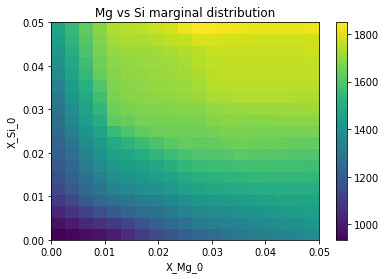

In [467]:
plt.pcolormesh(realvals1, realvals2, marginal_dist.T)
plt.xlabel(var1)
plt.ylabel(var2)
plt.colorbar()
plt.title('Mg vs Si marginal distribution')

# compute all marginal distributions
new method that requires very little memory, and does not significantly increase computation time. 

store only marginal distributions in memory, so never actually know full joint distribution.<br>
This reduces memory use from 10^7 ints (N=10 bins) to 10^2*28 ~ 3x10^3 ints. 

Time to compute scales as N^7 (for 7 dimensions), with N=10 taking ~ 15min on macbook air. or 1.5min / 1e6 iters<br>
N=12 should be ~45 min. Don't suggest going higher.

In [459]:
N = 4 ## takes ~45 min to run N=12 with 7 variables. Beware turning it about that. 
var1 = 'X_Mg_0'
var2 = 'X_Si_0'
p_cutoff = 0.05

te = -time.time()
Nvars = len(ri_pd.index.names)
mdax1, realvals1 = get_interpolation_coords(ri_pd, var1, Ninterp=N, return_vals_wanted=True)
mdax2, realvals2 = get_interpolation_coords(ri_pd, var2, Ninterp=N, return_vals_wanted=True)
MDs = np.empty((Nvars,Nvars,N,N), dtype=int)
# MDtot = np.empty((Nvars,Nvars,N,N), dtype=int)

for i in range(Nvars):
    for j in range(i+1, Nvars):
        MDs[i,j,:,:] = 0
#         MDtot[i,j,:,:] = 0
KDs = np.zeros((Nvars,N), dtype=int)
# KDtot = np.zeros((Nvars,N), dtype=int)

int_names, int_coords, int_realvals = setup_all_interpolation_axes(ri_pd, Ninterp=N)
int_inds = [range(N)]*Nvars
int_coord_and_inds = [[(c,i) for c,i in zip(ci,ii)] for ci,ii in zip(int_coords,int_inds)]


real_ri = 1220e3
c_ind = it.product(*int_coord_and_inds, repeat=1)
for c in c_ind:
    arr = np.array(c)
    pcoor = arr[:,0]
    inds = np.array(arr[:,1], dtype=int)
    # pind = it.product(*int_inds, repeat=1)
    # prod = it.product(*int_coords, repeat=1)
    # for p,inds in zip(prod,pind):
#     for i in range(Nvars):
#         KDtot[i,inds[i]]+=1
#         for j in range(i+1, Nvars):
#             MDtot[i,j,inds[i],inds[j]] += 1
    if (sim.map_coordinates(ri_arr, np.array([pcoor]).T, order=1)-real_ri)/real_ri < p_cutoff:
        for i in range(Nvars):
            KDs[i,inds[i]]+=1
            for j in range(i+1, Nvars):
                MDs[i,j,inds[i],inds[j]] += 1
te += time.time()
# times.append(te)

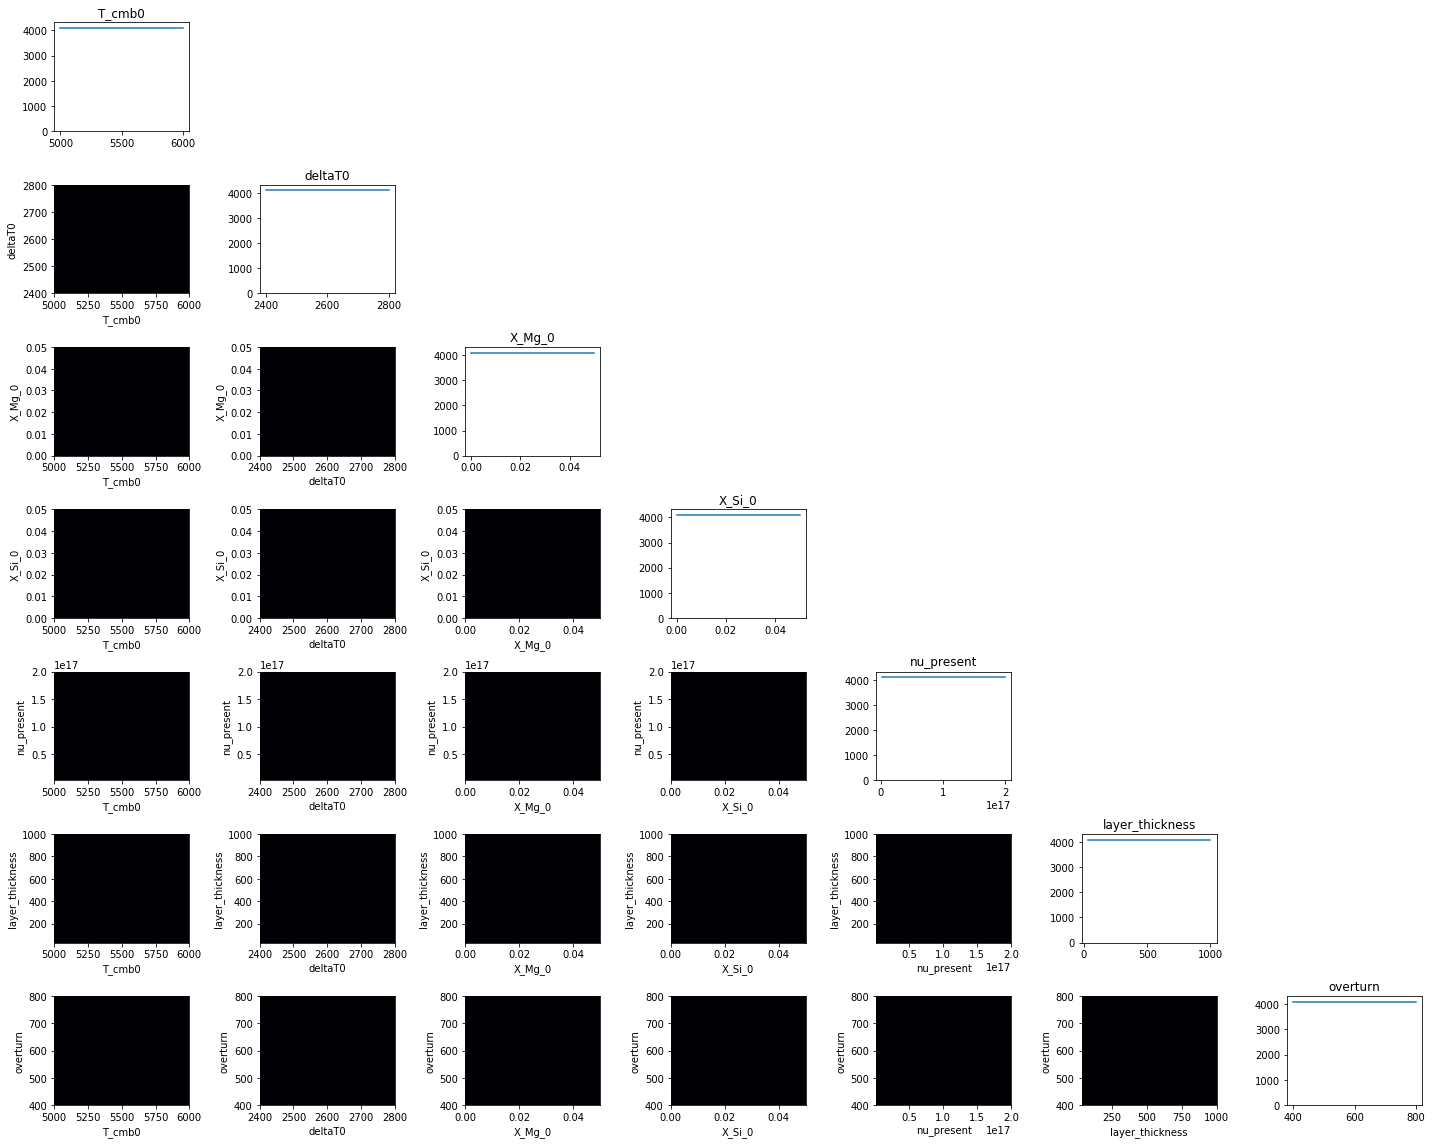

In [461]:
i = 0
j = 1
plt.figure(figsize=(20,16))
vmax = np.log10(np.max(MDs[0,1,:,:]))+1
vmin = vmax-4
V = np.linspace(vmin,vmax,21)
for i in range(Nvars):
    plt.subplot(Nvars,Nvars, i+i*Nvars+1)
    plt.plot(int_realvals[i], KDtot[i])
    plt.title(ri_pd.index.names[i])
    plt.ylim(0,)
    for j in range(i+1,Nvars):
        plt.subplot(Nvars,Nvars,i+Nvars*j+1)
        plt.pcolormesh(int_realvals[i], int_realvals[j], (MDtot[i,j]+1e-5).T, cmap=plt.cm.inferno)
        plt.xlabel(int_names[i])
        plt.ylabel(int_names[j])
#         plt.colorbar()
plt.tight_layout()
plt.savefig('MarginalDistributions.png')

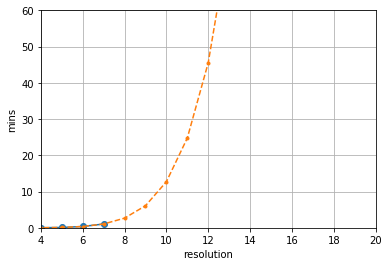

In [377]:
Nvars = 7
combs = np.array(Ns)**Nvars

# plt.plot(combs, times)
pf = np.polyfit(combs, times, deg=1)
Nt = np.array(range(3,21))
yf =np.polyval(pf,Nt**Nvars)
plt.plot(Ns, np.array(times)/60,'-o')
plt.plot(Nt, yf/60,'--.')
plt.ylim(0,60)
plt.ylabel('mins')
plt.xlim(4,20)
plt.xlabel('resolution')
plt.grid()

# Old Code
computes all interpolations first, then plots slices of matrix. prohibitively memory-intensive

In [6]:
Nfit = 4
fcoords = [] # interpolated index locations of values in dataset
fvals = [] # values in dataset 
fnames = [] # names of fit axes
for ind in ri_pd.index.levels:
    vals = ind.values
    fnames.append(ind.name)
    mi = vals.min()
    ma = vals.max()
    fitvals = np.linspace(mi,ma,Nfit)
    fitcoords = np.interp(fitvals, vals, range(len(vals)))
    fcoords.append(fitcoords)
    fvals.append(fitvals)
    
# warning, if prodsize is > 10^7 it might take a LONG time
print('{}, prodsize={:.2e}'.format(len(fcoords), Nfit**len(fcoords)))
prod = it.product(*fcoords, repeat=1)

7, prodsize=1.64e+04


In [7]:
# compute the inner core radius by interpolating between data
fit_ri = []
for p in prod:
    fit_ri.append(sim.map_coordinates(ri_arr, np.array([p]).T, order=1))
fit_ri = np.array(fit_ri)
fit_ri = fit_ri.reshape([len(c) for c in fcoords])

In [ ]:
# percent misfit from real inner core radius
real_ri = 1220e3
ri_poff = (fit_ri-real_ri)/real_ri-1

In [ ]:
# names of parameters that vary
fnames

In [ ]:
def plot_2ax_setothers(name1,name2, set_vals):
    '''plot 2 vars vs each other, while keeping others constant'''
    arr2plt = np.copy(ri_poff)
    i = np.array(range(arr2plt.shape[0]))
    ii,jj = np.meshgrid(i,i)
    inds = [[]]*len(arr2plt.shape)
    #inds = []*len(arr2plt.shape)
    title = ''
    for n,v in set_vals.items():
        find = fnames.index(n)
        ci = int(np.interp(v,fvals[find],range(Nfit)))
        inds[find] = ci
        if n =='nu_present':
            title +=' {}={}'.format(n,np.log10(v*5500))
        else:
            title +=' {}={}'.format(n,v)
    inds[fnames.index(name1)] = ii
    inds[fnames.index(name2)] = jj
#     print(arr2plt.shape)
    arr2plt = arr2plt[tuple(inds)]
#     print(arr2plt.shape)
    fi1 = fnames.index(name1)
    fi2 = fnames.index(name2)
    if name1 == 'nu_present':
        x = np.log10(fvals[fi1]*5500.)
    else:
        x = fvals[fi1]
    if name2 == 'nu_present':
        y = np.log10(fvals[fi2]*5500.)
    else:
        y = fvals[fi2]
    plt.pcolormesh(x,y,arr2plt, vmin=-.5, vmax=.5, cmap=plt.cm.RdBu)
    plt.colorbar(label='Ri % misfit')
    plt.xlabel(name1)
    plt.ylabel(name2)
    plt.title(title)
    

In [ ]:
name1 = 'T_cmb0'
name2 = 'nu_present'
set_vals = {'X_Mg_0':1e-5, 'X_Si_0':1e-5, 'layer_thickness':100,'deltaT0':2800,'overturn':800}
plt.figure(figsize=(28,14))
Xvs = [1e-5, 0.01, 0.25, 0.05]
n = len(Xvs)
for i in range(n):
    for j in range(n):
        set_vals['X_Mg_0'] = Xvs[i]
        set_vals['X_Si_0'] = Xvs[j]
        plt.subplot(n,n,i*n+j+1)
        plot_2ax_setothers(name1, name2, set_vals)
plt.tight_layout()
plt.savefig('../computed_solutions_new/plots/TvsNu.png')
plt.close()

In [ ]:
name1 = 'X_Si_0'
name2 = 'X_Mg_0'
set_vals = {'T_cmb0':5200, 'nu_present':10**20.5/5500, 'layer_thickness':100,'deltaT0':2800,'overturn':800}
plt.figure(figsize=(28,16))
Tcmbs = [5000,5100,5200,5300,5400]
n = len(Tcmbs)
nus = (10**np.linspace(20,21,n))/5500
for i in range(n):
    for j in range(n):
        set_vals['T_cmb0'] = Tcmbs[i]
        set_vals['nu_present'] = nus[j]
        plt.subplot(n,n,i*n+j+1)
        plot_2ax_setothers(name1, name2, set_vals)
#         plt.colorbar(label=None)
        if i==0 and j==0:
            plt.title('Tc={},nu={}'.format(Tcmbs[i], np.log10(nus[j]*5500)))
        elif i==0:
            plt.title('nu={}'.format(np.log10(nus[j]*5500)))
        elif j==0:
            plt.title('Tc={}'.format(Tcmbs[i]))
        else:
            plt.title('')
            
        if j==0:
            plt.ylabel('X_Mg')
        else:
            plt.ylabel('')
            
        if i==n-1:
            plt.xlabel('X_Si')
        else:
            plt.xlabel('')
plt.tight_layout()
plt.savefig('../computed_solutions_new/plots/MgvsSi_h{:4.0f}m.png'.format(set_vals['layer_thickness']))
plt.close()
#############################################################

name1 = 'X_Si_0'
name2 = 'X_Mg_0'
set_vals = {'T_cmb0':5200, 'nu_present':10**20.5/5500, 'layer_thickness':100,'deltaT0':2800,'overturn':800}
plt.figure(figsize=(28,16))
Tcmbs = [5500,5600,5700,5800,5900]
n = len(Tcmbs)
nus = (10**np.linspace(20,21,n))/5500
for i in range(n):
    for j in range(n):
        set_vals['T_cmb0'] = Tcmbs[i]
        set_vals['nu_present'] = nus[j]
        plt.subplot(n,n,i*n+j+1)
        plot_2ax_setothers(name1, name2, set_vals)
#         plt.colorbar(label=None)
        if i==0 and j==0:
            plt.title('Tc={},nu={}'.format(Tcmbs[i], np.log10(nus[j]*5500)))
        elif i==0:
            plt.title('nu={}'.format(np.log10(nus[j]*5500)))
        elif j==0:
            plt.title('Tc={}'.format(Tcmbs[i]))
        else:
            plt.title('')
            
        if j==0:
            plt.ylabel('X_Mg')
        else:
            plt.ylabel('')
            
        if i==n-1:
            plt.xlabel('X_Si')
        else:
            plt.xlabel('')
plt.tight_layout()
plt.savefig('../computed_solutions_new/plots/MgvsSi2_h{:4.0f}m.png'.format(set_vals['layer_thickness']))
plt.close()

In [ ]:
def plot_2ax_sumelse(a1, a2):
    ''' plot 2 vars vs each other, with number of runs 
    within a certain % summed over other variables'''
    sax = list(range(len(ri_close.shape)))
    sax.remove(a1)
    sax.remove(a2)
    s = np.sum(ri_close, axis=tuple(sax))
    if fnames[a1] == 'nu_present':
        x = np.log10(fvals[a1]*5500.)
    else:
        x = fvals[a1]
    if fnames[a2] == 'nu_present':
        y = np.log10(fvals[a2]*5500.)
    else:
        y = fvals[a2]        
    xx,yy = np.meshgrid(x, y)
    plt.pcolormesh(xx,yy,s, cmap=plt.cm.jet)
    plt.xlabel(fnames[a1])
    plt.ylabel(fnames[a2])
    plt.colorbar(label='# of runs')
#     plt.title('Inner Core Radius within 10%')

In [ ]:
# compute the number of runs within a certain % of the real inner core size
# at various parameters
p_cutoff = 0.05
for p_cutoff in [0.01, 0.05, 0.1, 0.2, 0.5]:
    ri_close = np.zeros_like(fit_ri)
    ri_close[np.where(np.abs(ri_poff)<p_cutoff)] = 1.
    plt.figure(figsize=(18,14))
    # plt.suptitle('IC R within 10%')
    for a1 in range(5):
        for a2 in range(a1+1,5):
            plt.subplot(5,5,a1+a2*5+1)
            plot_2ax_sumelse(a1,a2)
    plt.tight_layout()
    plt.savefig('../computed_solutions_new/plots/Ri_within{:.0f}p.png'.format(p_cutoff*100))
    plt.close()